In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa.core as lc
import IPython.display as ipd

import dataset_loader.music_loader_stft

In [2]:
loader = dataset_loader.music_loader_stft.MusicLoader('data/fma_xs', split='train')

ft shape (1025, 129)


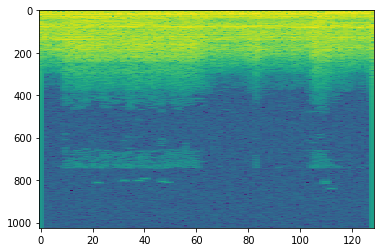

In [8]:
i = np.random.randint(len(loader))
sampling_rate = 44100

a = loader[i]
signal = loader.get_raw(i)
reconstruct = loader.spec_to_audio(a, i)
reconstruct_no_phase = loader.spec_to_audio(a)

plt.imshow(a, aspect='auto')
print('ft shape', a.shape)

In [4]:
# Original audio

ipd.Audio(signal, rate=sampling_rate)

In [5]:
# Reconstructed from STFT, with phase information from original data

ipd.Audio(reconstruct, rate=sampling_rate)

In [6]:
# Reconstructed from STFT, with phase information from original data

ipd.Audio(reconstruct_no_phase, rate=sampling_rate)

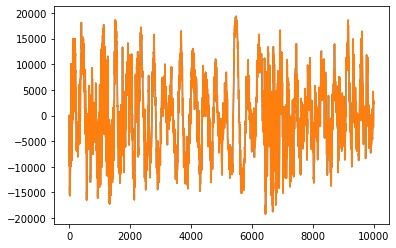

In [7]:
# Plot original vs reconstructed

plt.plot(signal[:10000])
plt.plot(reconstruct[:10000])